## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Наша цель проста, но реальная реализация может занять некоторое время :). Мы собираемся написать искусственную нейронную сеть (почти) с нуля. Дизайн программного обеспечения был во многом вдохновлен [PyTorch] (http://pytorch.org), который является основной структурой нашего курса.

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

Реализуйте все в `modules.ipynb`. Внимательно прочтите все комментарии, чтобы облегчить боль. Пожалуйста, постарайтесь не менять прототипы.

Не забывайте, что каждый модуль должен возвращать ** И ** store `output` и` gradInput`.

Типичное предположение состоит в том, что `module.backward` всегда выполняется после` module.forward`,
так что output сохраняется, это может быть полезно для SoftMax.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [11]:
# (re-)load layers
%run M21.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

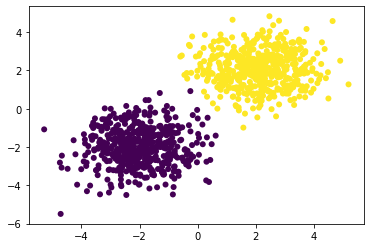

In [18]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [19]:
print(X.shape)
print(Y.shape)

(1000, 2)
(1000, 2)


Define a **logistic regression** for debugging. 

In [23]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [24]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [25]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

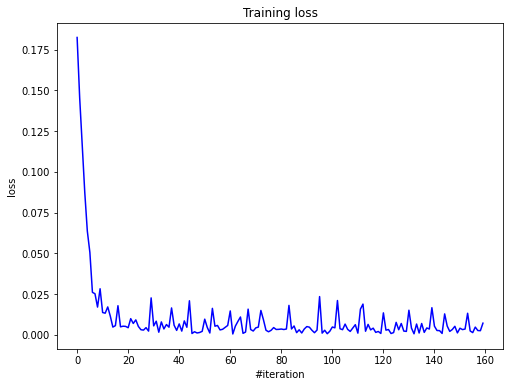

Current loss: 0.007068


In [26]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [61]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [62]:
X_test = 1. * X_test / np.max(X_test)  # normalize
X_val = 1. * X_val / np.max(X_val)
X_train = 1. * X_train / np.max(X_train)

In [63]:
X_test = X_test.reshape(len(X_test), -1)
print(X_test.shape)
X_val = X_val.reshape(len(X_val), -1)
print(X_val.shape)
X_train = X_train.reshape(len(X_train), -1)
print(X_train.shape)

(10000, 784)
(10000, 784)
(50000, 784)


One-hot encode the labels first.

In [65]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
print(y_train.shape)
encoder = OneHotEncoder()
y_val = encoder.fit_transform(y_val).toarray()
print(y_val.shape)
encoder = OneHotEncoder()
y_test = encoder.fit_transform(y_test).toarray()
print(y_test.shape)

(50000, 10)
(10000, 10)
(10000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [90]:
losses = {'ReLU': [], "ELU": [], 'LeakyReLU': [], "SoftPlus": []}
losses_b = {'ReLU + BatchNormalization': [], "ELU + BatchNormalization": [], 'LeakyReLU + BatchNormalization': [],
          "SoftPlus + BatchNormalization": []}

# Сравнение функций активации

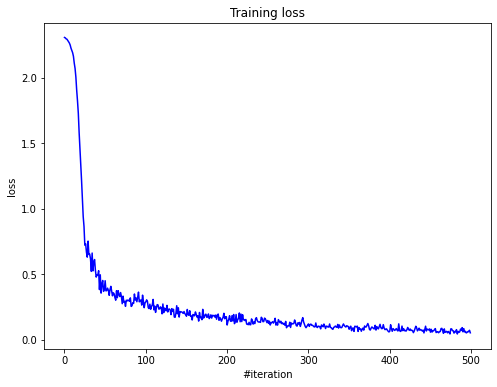

Current loss: 0.051681


In [91]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(ReLU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(ReLU())

net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state) 
        loss_history.append(loss)
        losses['ReLU'].append(loss)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f' % loss)

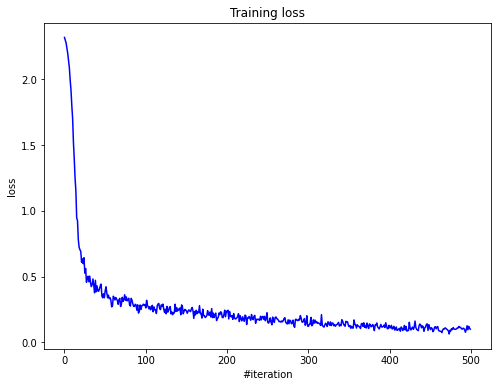

Current loss: 0.100616


In [92]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(ELU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(ELU())
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        losses['ELU'].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()    
    print('Current loss: %f' % loss)

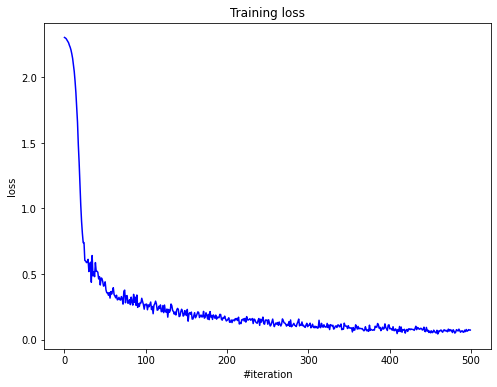

Current loss: 0.072399


In [93]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(LeakyReLU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(LeakyReLU())
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 1000


loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        losses['LeakyReLU'].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

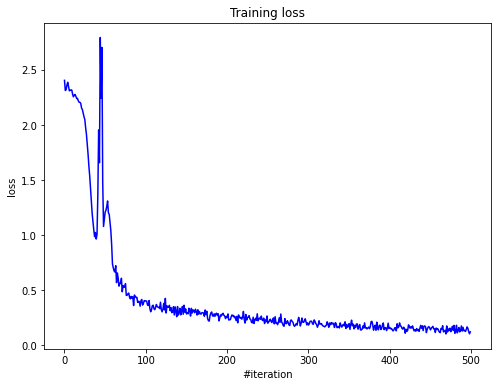

Current loss: 0.123208


In [94]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(SoftPlus())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(SoftPlus())
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net)
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)     
        
        loss_history.append(loss)
        losses['SoftPlus'].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

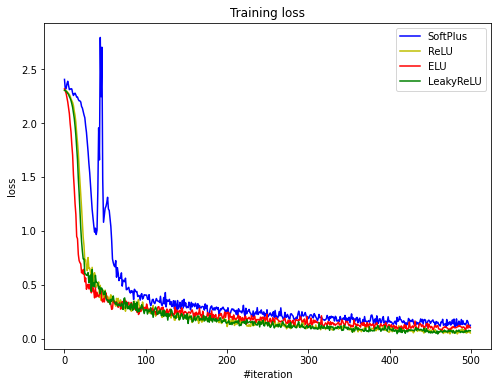

In [95]:
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(losses['SoftPlus'], 'b', label="SoftPlus")
plt.plot(losses['ReLU'], 'y', label="ReLU")
plt.plot(losses['ELU'], 'r', label="ELU")
plt.plot(losses['LeakyReLU'], 'g', label="LeakyReLU")
plt.legend()
plt.show()

In [115]:
print('LeakyReLU', sum(losses['LeakyReLU']) / len(losses['LeakyReLU']))
print('ReLU', sum(losses['ReLU']) / len(losses['ReLU']))
print('ELU', sum(losses['ELU']) / len(losses['ELU']))
print('SoftPlus', sum(losses['SoftPlus']) / len(losses['SoftPlus']))

LeakyReLU 0.24625101479378456
ReLU 0.2549084690187734
ELU 0.2546617075333329
SoftPlus 0.42690900441361485


## По графику и среднему видно, что результат с функцией активации LeakyReLU лучше.

# Сравнение функций активации + BatchNormalization

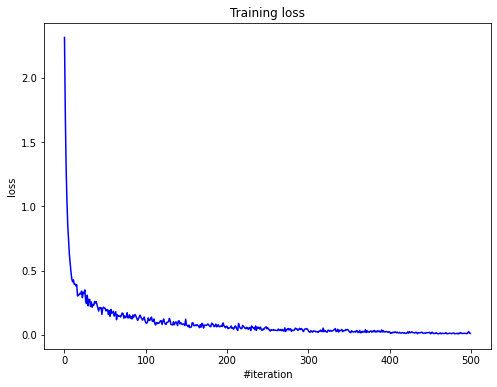

Current loss: 0.011817


In [97]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(ReLU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(ReLU())
net.add(BatchNormalization(0.4))
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state) 
        loss_history.append(loss)
        losses_b['ReLU + BatchNormalization'].append(loss)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f' % loss)

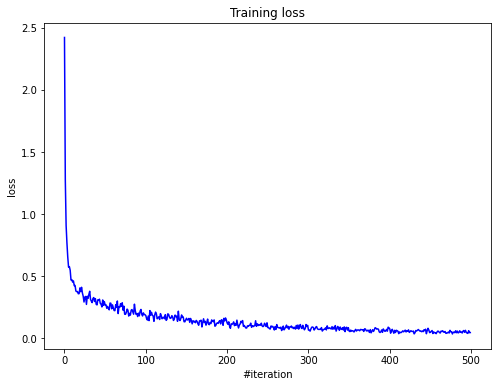

Current loss: 0.047147


In [98]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(ELU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(ELU())
net.add(BatchNormalization(0.4))
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        losses_b['ELU + BatchNormalization'].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()    
    print('Current loss: %f' % loss)

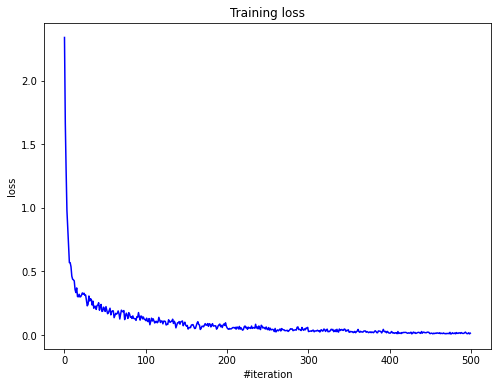

Current loss: 0.014713


In [99]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(LeakyReLU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(LeakyReLU())
net.add(BatchNormalization(0.4))
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 1000


loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        losses_b['LeakyReLU + BatchNormalization'].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

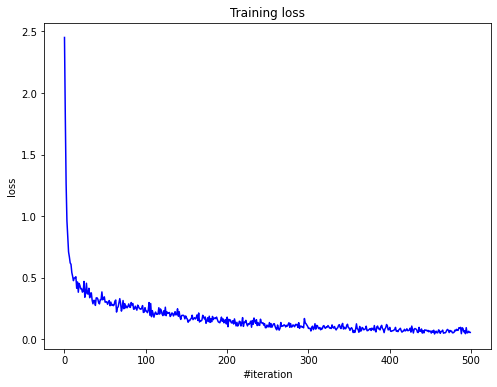

Current loss: 0.055455


In [100]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(SoftPlus())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(SoftPlus())
net.add(BatchNormalization(0.4))
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net)
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)     
        
        loss_history.append(loss)
        losses_b['SoftPlus + BatchNormalization'].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

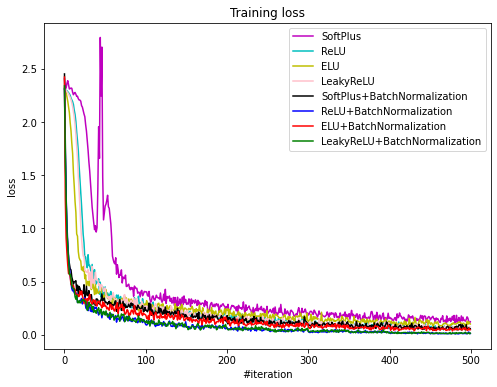

In [109]:
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(losses['SoftPlus'], 'm', label="SoftPlus")
plt.plot(losses['ReLU'], 'c', label="ReLU")
plt.plot(losses['ELU'], 'y', label="ELU")
plt.plot(losses['LeakyReLU'], 'pink', label="LeakyReLU")
plt.plot(losses_b['SoftPlus + BatchNormalization'], 'k', label="SoftPlus+BatchNormalization")
plt.plot(losses_b['ReLU + BatchNormalization'], 'b', label="ReLU+BatchNormalization")
plt.plot(losses_b['ELU + BatchNormalization'], 'r', label="ELU+BatchNormalization")
plt.plot(losses_b['LeakyReLU + BatchNormalization'], 'g', label="LeakyReLU+BatchNormalization")

plt.legend()
plt.show()

In [119]:
print('LeakyReLU', sum(losses['LeakyReLU']) / len(losses['LeakyReLU']))
print('ReLU', sum(losses['ReLU']) / len(losses['ReLU']))
print('ELU', sum(losses['ELU']) / len(losses['ELU']))
print('SoftPlus', sum(losses['SoftPlus']) / len(losses['SoftPlus']))

print('LeakyReLU+BatchNormalization', sum(losses_b['LeakyReLU + BatchNormalization']) / len(losses_b['LeakyReLU + BatchNormalization']))
print('ReLU+BatchNormalization', sum(losses_b['ReLU + BatchNormalization']) / len(losses_b['ReLU + BatchNormalization']))
print('ELU+BatchNormalization', sum(losses_b['ELU + BatchNormalization']) / len(losses_b['ELU + BatchNormalization']))
print('SoftPlus+BatchNormalization', sum(losses_b['SoftPlus + BatchNormalization']) / len(losses_b['SoftPlus + BatchNormalization']))

LeakyReLU 0.24625101479378456
ReLU 0.2549084690187734
ELU 0.2546617075333329
SoftPlus 0.42690900441361485
LeakyReLU+BatchNormalization 0.09525168627986053
ReLU+BatchNormalization 0.09271737385873043
ELU+BatchNormalization 0.14300708752618588
SoftPlus+BatchNormalization 0.17206372219792032


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

## BatchNormalization улучщает результаты. По графику и среднему видно, что результат с функцией активации ReLU  и с BatchNormalization лучше.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `+()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

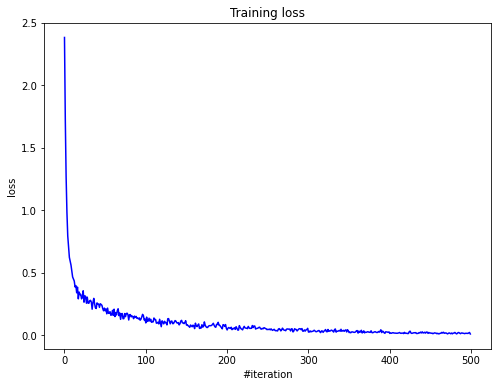

Current loss: 0.008466


In [129]:
net = Sequential()
net.add(Linear(X_train.shape[1], X_train.shape[1] // 4))
net.add(ReLU())
net.add(Linear(X_train.shape[1] // 4, X_train.shape[1] // 8))
net.add(ReLU())
net.add(BatchNormalization(0.4))
net.add(Linear(X_train.shape[1] // 8, 10))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
# Looping params
n_epoch = 10
batch_size = 1000
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        net.zeroGradParameters()        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state) 
        loss_history.append(loss)
        losses_b['ReLU + BatchNormalization'].append(loss)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f' % loss)

Print here your accuracy on test set. It should be around 90%.

In [131]:
# Your answer goes here. ################################################
net.training = False
pred = net.forward(X_test)

print('accuracy: {}'.format(float((pred.argmax(axis = 1) == y_test.argmax(axis = 1)).sum(0)) / pred.shape[0]))

accuracy: 0.9806


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__